## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
from tensorflow import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
# from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# use this to change which GPU to use
# gpu = 0

# # set the modified tf session as backend in keras
# setup_gpu(gpu)

/media/ghost/71f17ea4-f157-44e3-8ec8-4d543ed39935/home/gh05t/envs/ghost/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/ghost/71f17ea4-f157-44e3-8ec8-4d543ed39935/home/gh05t/envs/ghost/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/ghost/71f17ea4-f157-44e3-8ec8-4d543ed39935/home/gh05t/envs/ghost/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) 

## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('..', 'snapshots', 'resnet152_oid_v1.0.0.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet152')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person'}

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


/media/ghost/71f17ea4-f157-44e3-8ec8-4d543ed39935/home/gh05t/envs/ghost/lib/python3.7/site-packages/Keras-2.2.4-py3.7.egg/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
LEVEL_1_LABELS = ['Accordion', 'Adhesive tape', 'Airplane', 'Alarm clock', 'Alpaca', 'Ambulance', 'Ant', 'Antelope',
                  'Apple', 'Artichoke', 'Asparagus', 'Backpack', 'Bagel', 'Balloon', 'Banana', 'Barge', 'Barrel',
                  'Baseball bat', 'Baseball glove', 'Bat', 'Bathroom cabinet', 'Bathtub', 'Beaker', 'Bee', 'Beehive',
                  'Beer', 'Bell pepper', 'Belt', 'Bench', 'Bicycle', 'Bicycle helmet', 'Bicycle wheel', 'Bidet',
                  'Billboard', 'Billiard table', 'Binoculars', 'Blender', 'Blue jay', 'Book', 'Bookcase', 'Boot',
                  'Bottle', 'Bow and arrow', 'Bowl', 'Box', 'Boy', 'Brassiere', 'Bread', 'Briefcase', 'Broccoli',
                  'Bronze sculpture', 'Brown bear', 'Bull', 'Burrito', 'Bus', 'Bust', 'Butterfly', 'Cabbage',
                  'Cabinetry', 'Cake', 'Cake stand', 'Camel', 'Camera', 'Canary', 'Candle', 'Candy', 'Cannon',
                  'Canoe', 'Carrot', 'Cart', 'Castle', 'Cat', 'Caterpillar', 'Cattle', 'Ceiling fan', 'Cello',
                  'Centipede', 'Chair', 'Cheetah', 'Chest of drawers', 'Chicken', 'Chopsticks', 'Christmas tree',
                  'Coat', 'Cocktail', 'Coconut', 'Coffee', 'Coffee cup', 'Coffee table', 'Coffeemaker', 'Coin',
                  'Common fig', 'Computer keyboard', 'Computer monitor', 'Computer mouse', 'Convenience store',
                  'Cookie', 'Corded phone', 'Countertop', 'Cowboy hat', 'Crab', 'Cricket ball', 'Crocodile',
                  'Croissant', 'Crown', 'Crutch', 'Cucumber', 'Cupboard', 'Curtain', 'Cutting board', 'Dagger',
                  'Deer', 'Desk', 'Dice', 'Digital clock', 'Dinosaur', 'Dog', 'Dog bed', 'Doll', 'Dolphin',
                  'Door', 'Door handle', 'Doughnut', 'Dragonfly', 'Drawer', 'Dress', 'Drinking straw', 'Drum',
                  'Duck', 'Dumbbell', 'Eagle', 'Earrings', 'Egg', 'Elephant', 'Envelope', 'Falcon', 'Fedora',
                  'Filing cabinet', 'Fire hydrant', 'Fireplace', 'Flag', 'Flashlight', 'Flowerpot', 'Flute',
                  'Food processor', 'Football', 'Football helmet', 'Fork', 'Fountain', 'Fox', 'French fries',
                  'Frog', 'Frying pan', 'Gas stove', 'Giraffe', 'Girl', 'Glasses', 'Goat', 'Goggles', 'Goldfish',
                  'Golf ball', 'Golf cart', 'Gondola', 'Goose', 'Grape', 'Grapefruit', 'Guacamole', 'Guitar',
                  'Hamburger', 'Hamster', 'Handbag', 'Handgun', 'Harbor seal', 'Harp', 'Harpsichord', 'Headphones',
                  'Helicopter', 'High heels', 'Honeycomb', 'Horn', 'Horse', 'Hot dog', 'House', 'Houseplant',
                  'Human arm', 'Human beard', 'Human ear', 'Human eye', 'Human face', 'Human foot', 'Human hair',
                  'Human hand', 'Human head', 'Human leg', 'Human mouth', 'Human nose', 'Ice cream', 'Infant bed',
                  'Jacket', 'Jaguar', 'Jeans', 'Jellyfish', 'Jet ski', 'Jug', 'Juice', 'Kangaroo', 'Kettle',
                  'Kitchen & dining room table', 'Kitchen knife', 'Kite', 'Knife', 'Ladder', 'Ladybug', 'Lamp',
                  'Lantern', 'Laptop', 'Lavender', 'Lemon', 'Leopard', 'Lifejacket', 'Light bulb', 'Light switch',
                  'Lighthouse', 'Lily', 'Limousine', 'Lion', 'Lizard', 'Lobster', 'Loveseat', 'Lynx', 'Man',
                  'Mango', 'Maple', 'Measuring cup', 'Mechanical fan', 'Microphone', 'Microwave oven', 'Miniskirt',
                  'Mirror', 'Missile', 'Mixer', 'Mobile phone', 'Monkey', 'Motorcycle', 'Mouse', 'Muffin', 'Mug',
                  'Mule', 'Mushroom', 'Musical keyboard', 'Nail', 'Necklace', 'Nightstand', 'Oboe', 'Office building',
                  'Orange', 'Organ', 'Ostrich', 'Otter', 'Oven', 'Owl', 'Oyster', 'Paddle', 'Palm tree', 'Pancake',
                  'Paper towel', 'Parachute', 'Parrot', 'Pasta', 'Peach', 'Pear', 'Pen', 'Penguin', 'Piano',
                  'Picnic basket', 'Picture frame', 'Pig', 'Pillow', 'Pineapple', 'Pitcher', 'Pizza', 'Plastic bag',
                  'Plate', 'Platter', 'Polar bear', 'Pomegranate', 'Popcorn', 'Porch', 'Porcupine', 'Poster',
                  'Potato', 'Power plugs and sockets', 'Pressure cooker', 'Pretzel', 'Printer', 'Pumpkin',
                  'Punching bag', 'Rabbit', 'Raccoon', 'Radish', 'Raven', 'Refrigerator', 'Rhinoceros', 'Rifle',
                  'Ring binder', 'Rocket', 'Roller skates', 'Rose', 'Rugby ball', 'Ruler', 'Salad',
                  'Salt and pepper shakers', 'Sandal', 'Saucer', 'Saxophone', 'Scarf', 'Scissors', 'Scoreboard',
                  'Screwdriver', 'Sea lion', 'Sea turtle', 'Seahorse', 'Seat belt', 'Segway', 'Serving tray',
                  'Sewing machine', 'Shark', 'Sheep', 'Shelf', 'Shirt', 'Shorts', 'Shotgun', 'Shower', 'Shrimp',
                  'Sink', 'Skateboard', 'Ski', 'Skull', 'Skyscraper', 'Slow cooker', 'Snail', 'Snake', 'Snowboard',
                  'Snowman', 'Snowmobile', 'Snowplow', 'Sock', 'Sofa bed', 'Sombrero', 'Sparrow', 'Spatula',
                  'Spider', 'Spoon', 'Sports uniform', 'Squirrel', 'Stairs', 'Starfish', 'Stationary bicycle',
                  'Stool', 'Stop sign', 'Strawberry', 'Street light', 'Stretcher', 'Studio couch',
                  'Submarine sandwich', 'Suit', 'Suitcase', 'Sun hat', 'Sunflower', 'Sunglasses', 'Surfboard',
                  'Sushi', 'Swan', 'Swim cap', 'Swimming pool', 'Swimwear', 'Sword', 'Table tennis racket',
                  'Tablet computer', 'Taco', 'Tank', 'Tap', 'Tart', 'Taxi', 'Tea', 'Teapot', 'Teddy bear',
                  'Television', 'Tennis ball', 'Tennis racket', 'Tent', 'Tiara', 'Tick', 'Tie', 'Tiger', 'Tin can',
                  'Tire', 'Toaster', 'Toilet', 'Toilet paper', 'Tomato', 'Torch', 'Tortoise', 'Towel', 'Tower',
                  'Traffic light', 'Train', 'Training bench', 'Treadmill', 'Tripod', 'Trombone', 'Truck',
                  'Trumpet', 'Turkey', 'Umbrella', 'Van', 'Vase', 'Vehicle registration plate', 'Violin',
                  'Volleyball', 'Waffle', 'Wall clock', 'Washing machine', 'Waste container', 'Watch',
                  'Watermelon', 'Whale', 'Wheel', 'Wheelchair', 'Whiteboard', 'Willow', 'Window',
                  'Window blind', 'Wine', 'Wine glass', 'Winter melon', 'Wok', 'Woman', 'Wood-burning stove',
                  'Woodpecker', 'Wrench', 'Zebra', 'Zucchini']


LEVEL_2_LABELS = ['Toy', 'Home appliance', 'Plumbing fixture', 'Office supplies', 'Tableware', 'Kitchen appliance',
                  'Couch', 'Bed', 'Table', 'Clock', 'Sculpture', 'Traffic sign', 'Building', 'Person', 'Dessert',
                  'Fruit', 'Shellfish', 'Squash', 'Sandwich', 'Tree', 'Flower', 'Car', 'Boat', 'Aircraft', 'Hat',
                  'Skirt', 'Glove', 'Trousers', 'Footwear', 'Luggage and bags', 'Helmet', 'Bird',
                  'Marine invertebrates', 'Beetle', 'Moths and butterflies', 'Bear', 'Marine mammal', 'Turtle',
                  'Fish', 'Personal care', 'Musical instrument', 'Ball', 'Racket', 'Weapon', 'Telephone',
                  'Drink']

LEVEL_3_LABELS = ['Seafood', 'Watercraft', 'Insect', 'Carnivore']

# Some classes upper to make more than one class for single net
LEVEL_4_LABELS = ['Vegetable', 'Land vehicle', 'Reptile', 'Invertebrate']

# Some classes upper to make more than one class for single net
LEVEL_5_LABELS = ['Furniture', 'Vehicle', 'Animal']

# Classes with less than 500 samples in train
LEVEL_1_LABELS_LOW_SAMPLES = ['Adhesive tape', 'Alarm clock', 'Ambulance', 'Artichoke', 'Asparagus', 'Bathroom cabinet',
                              'Beaker', 'Belt', 'Bidet', 'Binoculars', 'Blender', 'Blue jay', 'Briefcase', 'Burrito',
                              'Cabbage', 'Cake stand', 'Canary', 'Ceiling fan', 'Centipede', 'Coffeemaker', 'Common fig',
                              'Corded phone', 'Cricket ball', 'Croissant', 'Crutch', 'Cutting board', 'Dagger',
                              'Digital clock', 'Dog bed', 'Drinking straw', 'Dumbbell', 'Envelope', 'Filing cabinet',
                              'Fire hydrant', 'Flashlight', 'Flute', 'Food processor', 'Frying pan', 'Golf ball',
                              'Guacamole', 'Harp', 'Harpsichord', 'Honeycomb', 'Hot dog', 'Infant bed',
                              'Kitchen knife', 'Light switch', 'Limousine', 'Lynx', 'Mango', 'Measuring cup',
                              'Microwave oven', 'Mixer', 'Nail', 'Oboe', 'Organ', 'Paper towel', 'Picnic basket',
                              'Pitcher', 'Popcorn', 'Porcupine', 'Power plugs and sockets', 'Pressure cooker',
                              'Pretzel', 'Printer', 'Punching bag', 'Raccoon', 'Ring binder', 'Rugby ball', 'Ruler',
                              'Salt and pepper shakers', 'Scissors', 'Screwdriver', 'Seahorse', 'Seat belt',
                              'Serving tray', 'Sewing machine', 'Shower', 'Slow cooker', 'Snowmobile', 'Snowplow',
                              'Spatula', 'Stationary bicycle', 'Stop sign', 'Stretcher', 'Submarine sandwich',
                              'Tiara', 'Tick', 'Toaster', 'Toilet paper', 'Torch', 'Towel', 'Training bench',
                              'Treadmill', 'Winter melon', 'Wood-burning stove', 'Wrench']

# All labels
ALL_LABELS = LEVEL_1_LABELS + LEVEL_2_LABELS + LEVEL_3_LABELS + LEVEL_4_LABELS + LEVEL_5_LABELS

## Run detection on example

processing time:  16.1415696144104


/media/ghost/71f17ea4-f157-44e3-8ec8-4d543ed39935/home/gh05t/envs/ghost/lib/python3.7/site-packages/keras_retinanet/utils/colors.py:18: UserWarning: Label 456 has no color, returning default.
  warnings.warn('Label {} has no color, returning default.'.format(label))


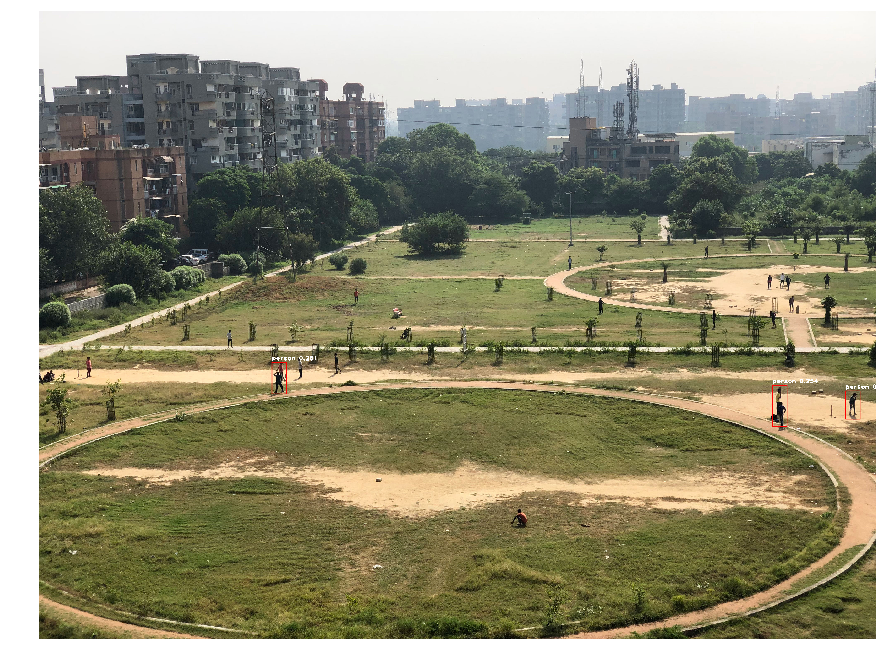

In [4]:
# load image
image = read_image_bgr('TopDownHumanDetection_4032x3024.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if label in [456, 230, 437, 453, 272]:
        if score < 0.2:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=(255, 0, 0))
        caption = "{} {:0.3f}".format('person', score)
        b = np.array(box).astype(int)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 4)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 4)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()